<a href="https://colab.research.google.com/github/100jy/voice_competition/blob/master/baseline_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

구글 드라이브 연동

In [ ]:
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


모듈 임포트

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
import keras
from tqdm import tqdm
from glob import glob
from scipy.io import wavfile
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
import librosa

# 음성에서 정형 데이터화

1. 음성신호 상태로 이용하는 방법 
2. MFCC이용하는 방법
3. spectogram 이용하는 방법

In [ ]:
# 데이터 로드 함수 정의 
def make_data(datalist, feature = 'signal'):

    arr = []
    #signal data
    if feature == 'signal':
        for file in tqdm(datalist):
            fs, data = wavfile.read(file)
            arr.append(data)
  
    #spectogam data
    elif feature == 'spectogram':
        for file in tqdm(datalist):
            x, sr = librosa.load(file)
            spec = librosa.stft(x)
            arr.append(spec.flatten())
  
    #MFCC data
    elif feature == 'MFCC':
        for file in tqdm(datalist):
            x, sr = librosa.load(file)
            mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=40, fmax=3000)
            arr.append(mfcc.flatten())
  
    else:
        raise ValueError

    result = np.array(arr)
    
    return result 

VAD하면 성능이 더 좋지 않을까???


트레인 셋 저장

In [ ]:
#signal 형태로 사용
raw_data = glob('data/train/*.wav')
#signal
signal = make_data(raw_data)
pd.DataFrame(signal).to_pickle('data/x_trian.pickle')
#specto
specto = make_data(raw_data, feature =  'spectogram')
pd.DataFrame(specto).to_pickle('data/x_trian_spectogram.pickle')
#MFCC
MFCC = make_data(raw_data, feature =  'MFCC')
pd.DataFrame(MFCC).to_pickle('data/x_trian_MFCC.pickle')
#feature = 
#x_train = pd.read_csv('data/train/x_train_{}.pickle'.format(feature))

테스트 셋 저장

In [ ]:
#signal 형태로 사용
raw_data = glob('drive/My Drive/data/test/*.wav')
#signal
signal = make_data(raw_data)
pd.DataFrame(signal).to_pickle('drive/My Drive/data/x_test.pickle')

데이터 불러오기


In [ ]:
#원본
x_train = pd.read_pickle('drive/My Drive/data/x_trian.pickle')
x_train = x_train.values
## ram 충분....
#x_train = x_train[:,::8]

In [ ]:
#MFCC
x_train = pd.read_pickle('drive/My Drive/data/x_trian_MFCC.pickle')
x_train = x_train.values

In [ ]:
# (0,1)로 정규화
x_train = list((map(lambda x : x / max(x),x_train)))
x_train =  np.array(x_train)
# 모델 넣기위한 reshape
## 채널 늘려보는 것도 의미있을듯...
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

In [ ]:
y_train = pd.read_csv('drive/My Drive/data/train_answer.csv',index_col=0)
y_train = y_train.values

x_train.shape, y_train.shape

((100000, 16000), (100000, 30))

# model architecture

In [ ]:
#CNN
model = Sequential()
model.add(Conv1D(16,32,activation='relu', input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(MaxPooling1D())
model.add(Conv1D(16,32,activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(16,32,activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(16,32,activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(16,32,activation='relu'))
model.add(Flatten())

#fully connected layer
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(30, activation='softmax'))
model.compile(loss=keras.losses.KLDivergence(), optimizer = 'adam')

In [ ]:
x_train.shape[1], x_train.shape[2]

(40, 44)

# model architecture fot 2D data

In [ ]:
##
x_train = x_train.reshape(x_train.shape[0], 40, -1,1)
#CNN
model = Sequential()
model.add(Conv2D(64, kernel_size = (3,3), strides = (1,1),activation='relu', input_shape = (x_train.shape[1], x_train.shape[2],1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))

'''
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(512, kernel_size = (3,3), strides = (1,1),activation='relu'))
'''
model.add(Flatten())

#fully connected layer
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(30, activation='softmax'))
model.compile(loss=keras.losses.KLDivergence(), optimizer = 'adam')
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 38, 42, 64)        640       
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 19, 21, 64)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 17, 19, 128)       73856     
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 8, 9, 128)         0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 6, 7, 128)         147584    
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1152)            

In [78]:
##
x_train = x_train.reshape(x_train.shape[0], 40, -1,1)
#CNN
model = Sequential()
model.add(Conv2D(64, kernel_size = (3,3), strides = (1,1),activation='relu', input_shape = (x_train.shape[1], x_train.shape[2],1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))
'''
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(512, kernel_size = (3,3), strides = (1,1),activation='relu'))
'''
model.add(Flatten())

#fully connected layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(30, activation='softmax'))
model.compile(loss=keras.losses.KLDivergence(), optimizer = 'adam')
model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_127 (Conv2D)          (None, 38, 42, 64)        640       
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 19, 21, 64)        0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 17, 19, 128)       73856     
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 8, 9, 128)         0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 6, 7, 128)         147584    
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 1152)            

# compile for signal



성능 구리다....

In [ ]:
model_path = 'drive/My Drive/data/model_signal/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

# validattion 기준 모델 갱신
model_file = model_path + 'epoch_{epoch:03d}_val_{val_loss:3f}.hdf5'
checkpoint = ModelCheckpoint(filepath = model_file, monitor = 'val_loss', verbose = 1, save_best_only =True)

#10회간 validatation 좋아지지 않으면 early stop
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(x_train, y_train, epochs = 100, batch_size = 256, validation_split = 0.2, shuffle = True,
                    callbacks = [checkpoint, early_stop])

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 603s 8ms/step - loss: 1.9820 - val_loss: 2.3312

Epoch 00001: val_loss improved from inf to 2.33122, saving model to drive/My Drive/data/model_signal/epoch_001_val_2.331218.hdf5
Epoch 2/100
80000/80000 [==============================] - 601s 8ms/step - loss: 1.8154 - val_loss: 2.2571

Epoch 00002: val_loss improved from 2.33122 to 2.25708, saving model to drive/My Drive/data/model_signal/epoch_002_val_2.257083.hdf5
Epoch 3/100
 3072/80000 [>.............................] - ETA: 9:14 - loss: 1.7442

KeyboardInterrupt: ignored

In [ ]:
# 훈련 결과를 확인합니다.
# validation 성능 fool하다....
plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
# 검증 wav 파일로부터 Feature를 만듭니다.
x_test = pd.read_pickle('drive/My Drive/data/x_test_normalized.pickle')
x_test = x_test.values
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# 가장 좋은 모델의 weight를 불러옵니다.
weigth_file = glob('drive/My Drive/data/model/*.hdf5')[-1]
print(weigth_file)
model.load_weights(weigth_file)

# 예측 수행
y_pred = model.predict(x_test)

# 예측 결과로 제출 파일을 생성합니다.
submission = pd.read_csv('drive/My Drive/data/submission.csv', index_col=0)
submission.loc[:, :] = y_pred
submission.to_csv('drive/My Drive/data/submission.csv')

# compile for MFCC

In [ ]:
model_path = 'drive/My Drive/data/model/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

# validattion 기준 모델 갱신
model_file = model_path + 'epoch_{epoch:03d}_val_{val_loss:3f}.hdf5'
checkpoint = ModelCheckpoint(filepath = model_file, monitor = 'val_loss', verbose = 1, save_best_only =True)

#10회간 validatation 좋아지지 않으면 early stop
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(x_train, y_train, epochs = 100, batch_size = 64, validation_split = 0.2, shuffle = True,
                    callbacks = [checkpoint, early_stop])

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 49s 612us/step - loss: 1.7428 - val_loss: 2.9026

Epoch 00001: val_loss improved from inf to 2.90256, saving model to drive/My Drive/data/model/epoch_001_val_2.902563.hdf5
Epoch 2/100
80000/80000 [==============================] - 48s 594us/step - loss: 1.5692 - val_loss: 2.1765

Epoch 00002: val_loss improved from 2.90256 to 2.17647, saving model to drive/My Drive/data/model/epoch_002_val_2.176467.hdf5
Epoch 3/100
80000/80000 [==============================] - 47s 591us/step - loss: 1.4897 - val_loss: 2.0291

Epoch 00003: val_loss improved from 2.17647 to 2.02906, saving model to drive/My Drive/data/model/epoch_003_val_2.029064.hdf5
Epoch 4/100
80000/80000 [==============================] - 47s 591us/step - loss: 1.4333 - val_loss: 1.9876

Epoch 00004: val_loss improved from 2.02906 to 1.98765, saving model to drive/My Drive/data/model/epoch_004_val_1.987646.hdf5
Epoch 5/100
80

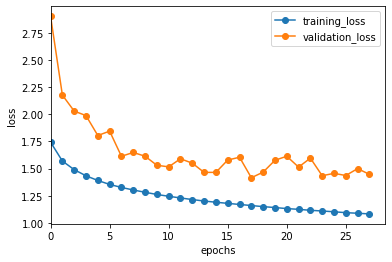

In [ ]:
# 훈련 결과를 확인합니다.
# validation 성능 fool하다....
plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [76]:
# 검증 wav 파일로부터 Feature를 만듭니다.

x_test = pd.read_pickle('drive/My Drive/data/x_test_MFCC.pickle')
x_test = x_test.values
x_test = list((map(lambda x : x / max(x),x_test)))
x_test =  np.array(x_test)
'''
x_test = pd.read_pickle('drive/My Drive/data/x_test_normalized.pickle')
x_test = x_test.values
#x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
'''
x_test = x_test.reshape(x_test.shape[0], 40,-1, 1)

# 가장 좋은 모델의 weight를 불러옵니다.
weigth_file = glob('drive/My Drive/data/model/*.hdf5')[-1]
print(weigth_file)
model.load_weights(weigth_file)

# 예측 수행
y_pred = model.predict(x_test)

# 예측 결과로 제출 파일을 생성합니다.
submission = pd.read_csv('drive/My Drive/data/submission.csv', index_col=0)
submission.loc[:, :] = y_pred
submission.to_csv('drive/My Drive/data/submission.csv')

drive/My Drive/data/model/epoch_018_val_1.415506.hdf5


# compile for MFCC_2D

In [ ]:
model_path = 'drive/My Drive/data/model_2D/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

# validattion 기준 모델 갱신
model_file = model_path + 'epoch_{epoch:03d}_val_{val_loss:3f}.hdf5'
checkpoint = ModelCheckpoint(filepath = model_file, monitor = 'val_loss', verbose = 1, save_best_only =True)

#10회간 validatation 좋아지지 않으면 early stop
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2, shuffle = True,
                    callbacks = [checkpoint, early_stop])

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 50s 630us/step - loss: 1.7138 - val_loss: 2.1147

Epoch 00001: val_loss improved from inf to 2.11473, saving model to drive/My Drive/data/model_2D/epoch_001_val_2.114732.hdf5
Epoch 2/100
80000/80000 [==============================] - 48s 606us/step - loss: 1.4997 - val_loss: 1.6575

Epoch 00002: val_loss improved from 2.11473 to 1.65754, saving model to drive/My Drive/data/model_2D/epoch_002_val_1.657537.hdf5
Epoch 3/100
80000/80000 [==============================] - 50s 620us/step - loss: 1.4024 - val_loss: 1.7540

Epoch 00003: val_loss did not improve from 1.65754
Epoch 4/100
80000/80000 [==============================] - 49s 611us/step - loss: 1.3344 - val_loss: 1.5757

Epoch 00004: val_loss improved from 1.65754 to 1.57574, saving model to drive/My Drive/data/model_2D/epoch_004_val_1.575745.hdf5
Epoch 5/100
80000/80000 [==============================] - 51s 636us/step - loss

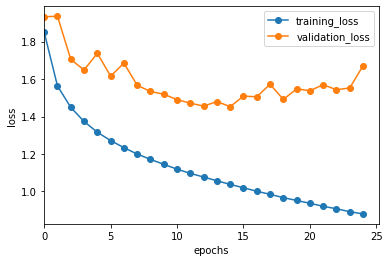

In [ ]:
# 훈련 결과를 확인합니다.
# validation 성능 fool하다....
plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [75]:
#x_test 문제있는거 같음...
# 검증 wav 파일로부터 Feature를 만듭니다.
x_test = pd.read_pickle('drive/My Drive/data/x_test_MFCC.pickle')
x_test = x_test.values
x_test = list((map(lambda x : x / max(x),x_test)))
x_test =  np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], 40,-1, 1)

# 가장 좋은 모델의 weight를 불러옵니다.
weigth_file = glob('drive/My Drive/data/model_2D/*.hdf5')[-1]
print(weigth_file)
model.load_weights(weigth_file)

# 예측 수행
y_pred = model.predict(x_test)

# 예측 결과로 제출 파일을 생성합니다.
submission = pd.read_csv('drive/My Drive/data/submission.csv', index_col=0)
submission.loc[:, :] = y_pred
submission.to_csv('drive/My Drive/data/submission.csv')

drive/My Drive/data/model_2D/epoch_015_val_1.452905.hdf5


ValueError: ignored

# 결과 구간화


행합이 1이 아닌 결과 값이 많음....(처리 필요함..)

In [ ]:
def make_step(vec):
  for i,con in enumerate(vec):
    interval = 0.125
    if 0<= con <interval:
      vec[i] = 0
    elif interval<= con < interval*2:
      vec[i] = 0.25
    elif interval*2<= con < interval*3:
      vec[i] = 0.75
    else:
      vec[i] = 1
    
    return vec

submission_step = list(map(make_step, submission.values))
submission_step = np.array(submission_step)

# 7/20 
**모델** : epoch_008_val_**1.724779**.hdf5(1D model)
  
**데이터**: x_trian_MFCC
  
**score** : ? (test set 잘못됨..) 

--------------------------------------

**모델** : epoch_015_val_**1.452905**.hdf5(2D model)
  
**데이터**: x_trian_MFCC
  
**score** : ?(test set 잘못됨..)

--------------------------------------

**모델** : epoch_018_val_**1.415506**.hdf5(2D model)
  
**데이터**: x_trian_MFCC
  
**score** : **1.4672**
